<a href="https://colab.research.google.com/github/DianaCarolinaCabrera/DianaCarolinaCabrera.github.io/blob/master/Text_classification_IMDB_BOW_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diana Carolina Cabrera Torres
* Mechatronics Engineer
* Master student Systems and Computing Engineering on Research modality
* Passionate About Data Science And Quantum Computing

# First challenge Machine Learning on text classification TFIDF
---

Durante las vacaciones estuve participando en WWC Data Science Community como asistente, en donde, aprendí y reforcé conceptos de procesamiento de lenguaje natural, algunas imagenes de TFIDF son tomadas de los notebooks compartidos en la comunidad.

### **Reminder: TF-IDF stands for “Term Frequency — Inverse Data Frequency”.** 

- Term Frequency (TF): gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf. 

![TF](https://cdn-media-1.freecodecamp.org/images/1*HM0Vcdrx2RApOyjp_ZeW_Q.png)


- Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below. 

![IDF](https://cdn-media-1.freecodecamp.org/images/1*A5YGwFpcTd0YTCdgoiHFUw.png)

Combining these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf: 

![TF-IDF formula](https://cdn-media-1.freecodecamp.org/images/1*nSqHXwOIJ2fa_EFLTh5KYw.png)

![formula](https://cdn-media-1.freecodecamp.org/images/1*q2tRgjV_J-MLvnhwNAl0KQ.png)

#### Let's automate this calculation process and utilize sklearn's built-in capabilities to calculate TF-IDF.

Refer to documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

###Goals 



> Scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative



![alt text](https://miro.medium.com/max/1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg)

In [2]:
pwd

'/content'

In [3]:
ls

sample_data/


## Load dataset + describe data

In [4]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
train = pd.read_csv('/content/sample_data/IMDB.csv', header=0, lineterminator='\n')
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train.head()

There are 50000 rows and 2 columns in the training set
There are 50000 rows and 2 columns in the training set after removing empty rows


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [31]:
train.isnull().sum()

review       0
sentiment    0
dtype: int64

#### Noise Cleaning


> Regex explanation:
1.   [^] matches everything but everything inside the blockquotes
2.   \w matches any word character (equal to [a-zA-Z0-9_])
3.   \d matches a digit (equal to [0-9])
4.   \s matches any whitespace character (equal to [\r\n\t\f\v ])
5.   \' matches the character ' literally (case sensitive)
6.   '+' matches between one and unlimited times, as many times as possible, giving back as needed

In [7]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['review'] = train['review'].str.lower()
train['review'] = train['review'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,petter mattei's love in the time of money is a...,1


In [8]:
#nltk tokenization

train['total_tokenize'] = train['review'].apply(word_tokenize)
train.head()

,review,sentiment,total_tokenize
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production br br the filmin...,1,"[a, wonderful, little, production, br, br, the..."
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically there's a family where a little boy ...,0,"[basically, there, 's, a, family, where, a, li..."
4,petter mattei's love in the time of money is a...,1,"[petter, mattei, 's, love, in, the, time, of, ..."


In [9]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Visualizations

In [10]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

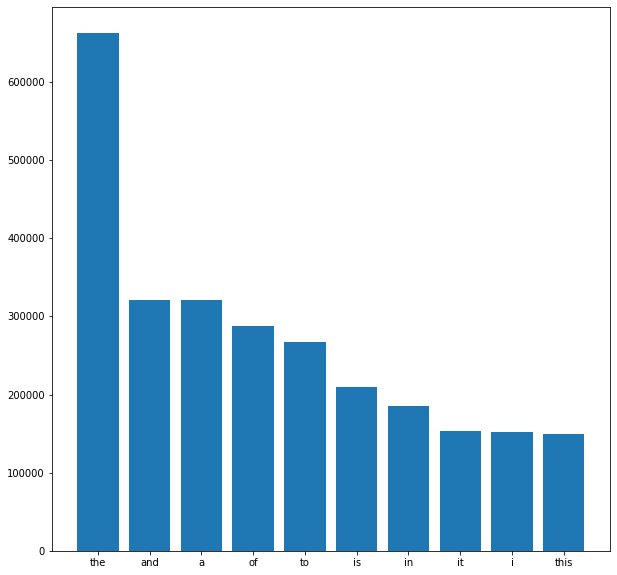

In [11]:
plot_top_stopwords_barchart(train['review'])

In [12]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)


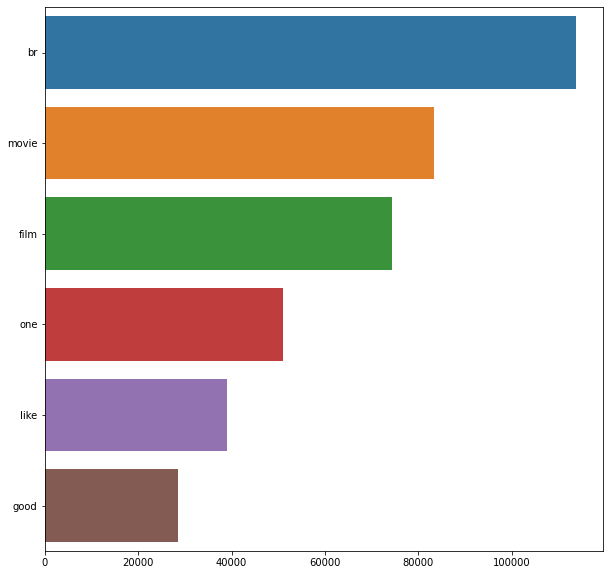

In [13]:
plot_top_non_stopwords_barchart(train['review'])

#### Remove stopwords

In [14]:
# Now we remove stopwords 

train['total_tokenize'] = train['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['total_tokenize_join'] = [' '.join(map(str, l)) for l in train['total_tokenize']]

train.head()

,review,sentiment,total_tokenize,total_tokenize_join
0,one of the other reviewers has mentioned that ...,1,"[one, reviewers, mentioned, watching, 1, oz, e...",one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production br br the filmin...,1,"[wonderful, little, production, br, br, filmin...",wonderful little production br br filming tech...
2,i thought this was a wonderful way to spend ti...,1,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,0,"[basically, 's, family, little, boy, jake, thi...",basically 's family little boy jake thinks 's ...
4,petter mattei's love in the time of money is a...,1,"[petter, mattei, 's, love, time, money, visual...",petter mattei 's love time money visually stun...


In [15]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

#### Yellow Brick: POS Visualizer

In [16]:
# Yellow Brick is a POS visualizer - https://github.com/DistrictDataLabs/yellowbrick/blob/master/docs/api/text/postag.rst
# You may need to reload the workbook to activate it. In that case, re-run all cells again from the beginning 

!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.1)


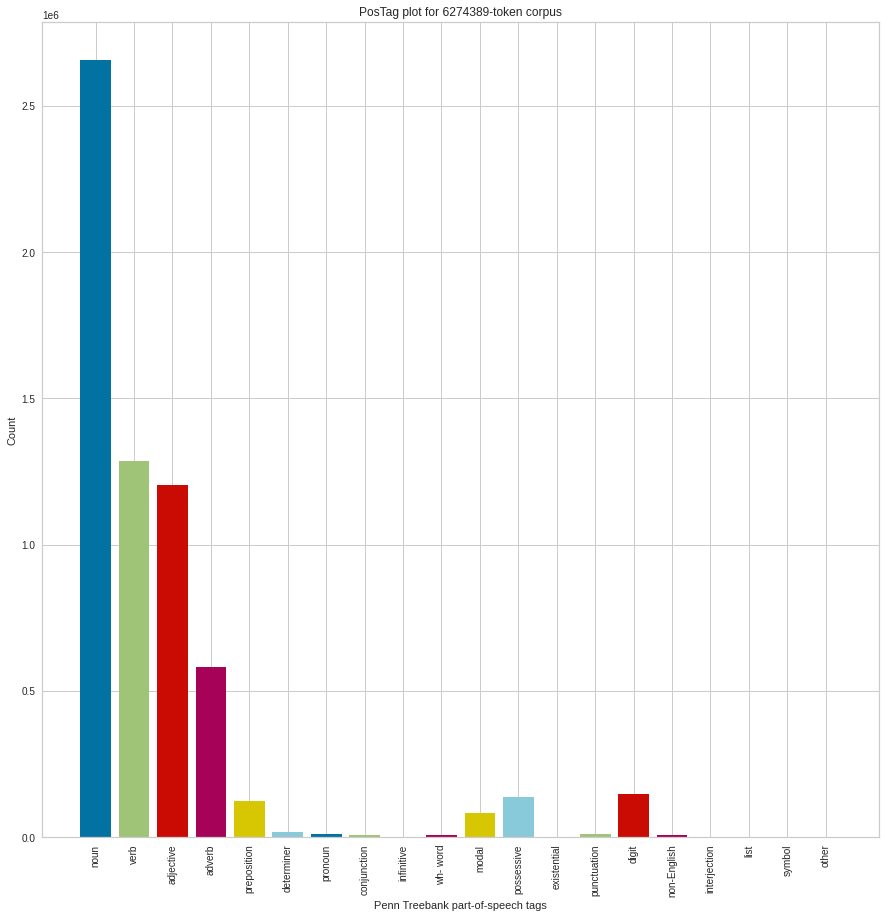

In [17]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

Some examples of POS Tags (via Universal Tagger)

Refer: http://www.nltk.org/book/ch05.html

![tagset](https://camo.githubusercontent.com/515359c32d2839f79bc166c07ff96fb70a0f82e5/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3730302f312a62444d64712d457061417232664c544e38344c6a67672e706e67)

## Text Classification

In [18]:
# Now let's check if number of examples for positive vs not-positive lasentimentbel is equal or not. Seems like in this case it's very balanced. 
train["sentiment"].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

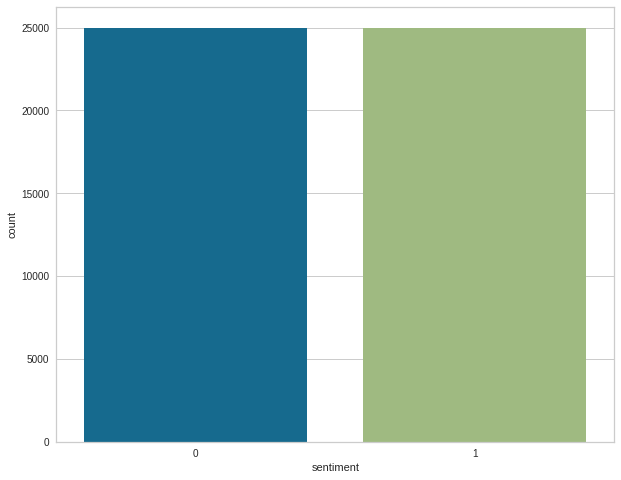

In [19]:
# we see there is an equal number of distribution of target features
rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["sentiment"])

In [20]:
# lets extract the sentiment column from train dataframe to be the target 'y' variable
targets = train['sentiment'].values

# Drop the 'label' column from train dataset
train.drop("sentiment", axis=1, inplace = True)
train.head()

,review,total_tokenize,total_tokenize_join
0,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, 1, oz, e...",one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production br br the filmin...,"[wonderful, little, production, br, br, filmin...",wonderful little production br br filming tech...
2,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,"[basically, 's, family, little, boy, jake, thi...",basically 's family little boy jake thinks 's ...
4,petter mattei's love in the time of money is a...,"[petter, mattei, 's, love, time, money, visual...",petter mattei 's love time money visually stun...


In [21]:
train.drop("total_tokenize", axis=1, inplace = True)
train.head()

,review,total_tokenize_join
0,one of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production br br the filmin...,wonderful little production br br filming tech...
2,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,basically 's family little boy jake thinks 's ...
4,petter mattei's love in the time of money is a...,petter mattei 's love time money visually stun...


In [22]:
train.drop("total_tokenize_join", axis=1, inplace = True)
train.head()

,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production br br the filmin...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,petter mattei's love in the time of money is a...


##Implement TF-IDF

Example: What kind of ngrams does range(1,2) create?

```
sentence = ["an apple a day keeps the doctor away"]
v=text.CountVectorizer(ngramrange=(1,2))

print(v.fit(sentence).vocabulary)

Result:
{'an': 0, 'apple': 2, 'day': 5, 'keeps': 9, 'the': 11, 'doctor': 7, 'away': 4, 'an apple': 1, 'apple day': 3, 'day keeps': 6, 'keeps the': 10, 'the doctor': 12, 'doctor away': 8}
```


In [23]:
import numpy as np
import tensorflow as tf

from os.path import join, exists, split
import os

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential, Model
from keras.layers import LSTM, merge, Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, GlobalMaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Concatenate, Reshape
#from keras.layers.merge import concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop
#from keras.layers import concatenate


import matplotlib.pyplot as plt

%matplotlib inline

In [156]:
# Model Hyperparameters
embedding_dim = 32
filter_sizes = (3, 5, 7, 9)
#filter_sizes = (3, 3, 3)
num_filters = 128
dropout_prob = (0.5, 0.0)

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 500
max_words = 5000


In [157]:
from sklearn.model_selection import train_test_split
#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train, targets, random_state=0)

In [158]:
X_train = X_train[:12500]
y_train = y_train[:12500]
X_test = X_test[:12500]
y_test = y_test[:12500]

In [159]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
X_train?

X_train shape: (12500, 1)
y_train shape: (12500,)
X_test shape: (12500, 1)
y_test shape: (12500,)


In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer

vectorizer = TfidfVectorizer(max_features=300)
vectorizer = vectorizer.fit(X_train)

df_train = vectorizer.transform(X_train)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [161]:
vectorizer = TfidfVectorizer(max_features=300)
vectorizer = vectorizer.fit(X_test)

df_test = vectorizer.transform(X_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)

In [162]:
import keras
from keras.layers import concatenate

sequences_train = tokenizer.texts_to_sequences(X_train)  
sequences_train = sequence.pad_sequences(sequences_train, maxlen=sequence_length, padding="post", truncating="post")

sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_test = sequence.pad_sequences(sequences_test, maxlen=sequence_length, padding="post", truncating="post")

#Retrieves a dict mapping words to their index in the IMDB dataset.
vocabulary_inv = len(tokenizer.word_index) + 1

print("X_train shape:", X_train.shape)
print("X_train shape:", sequences_train)

sequences_train?
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Vocabulary Size: {:d}".format(vocabulary_inv))


# # Input layer
input_tfidf = Input(shape=(300,))

input_shape = (sequence_length,)
model_input = Input(shape=input_shape)
# # Embedding layer
embedding_layer = Embedding(vocabulary_inv, embedding_dim, input_length=sequence_length, name="embedding")
# #embedding_layer = Flatten()(embedding_layer)
z = embedding_layer(model_input)

mean_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(z)
concatenated = concatenate([input_tfidf, mean_embedding])


X_train shape: (12500, 1)
X_train shape: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [163]:
print("sequence_length", sequence_length)
print("model_input", model_input)
print("Embedding Dim", embedding_dim)
print("Embedding layer", embedding_layer)
print("Embedding layer", z)
print("Vocabulary Size", concatenated)

sequence_length 500
model_input Tensor("input_16:0", shape=(None, 500), dtype=float32)
Embedding Dim 32
Embedding layer <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fc4164f4550>
Embedding layer Tensor("embedding/embedding_lookup_7/Identity_1:0", shape=(None, 500, 32), dtype=float32)
Vocabulary Size Tensor("concatenate_5/concat:0", shape=(None, 332), dtype=float32)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 32)      64          input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 32)           0           embedding[0][0]                  
_______________________________________________________________________________________

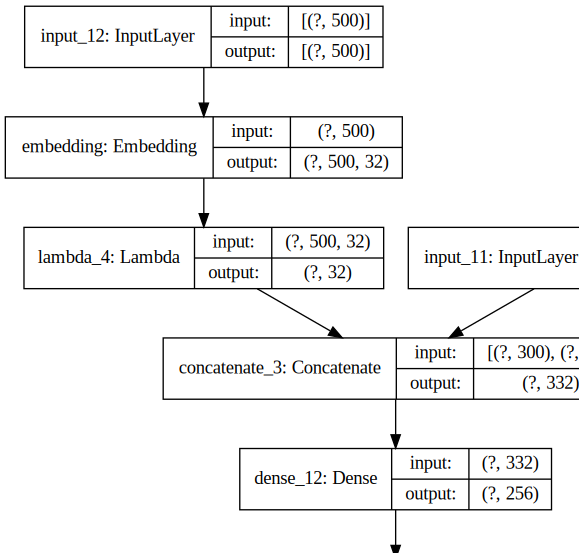

In [130]:
dense1 = Dense(256, activation='relu')(concatenated)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(8, activation='sigmoid')(dense2)

model = Model(inputs=[input_tfidf, model_input], outputs=dense3)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
model.summary(85)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [165]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [166]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['review'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)
train_tfidf

<50000x2672100 sparse matrix of type '<class 'numpy.float64'>'
	with 17199800 stored elements in Compressed Sparse Row format>

In [168]:
from sklearn.model_selection import train_test_split
#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)

In [169]:
X_train = X_train[:12500]
y_train = y_train[:12500]
X_test = X_test[:12500]
y_test = y_test[:12500]

In [170]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
X_train?

X_train shape: (12500, 2672100)
y_train shape: (12500,)
X_test shape: (12500, 2672100)
y_test shape: (12500,)


In [171]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.71


In [172]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))


Accuracy of Adaboost classifier on training set: 0.76
Accuracy of Adaboost classifier on test set: 0.73


In [173]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))



Accuracy of randomforest classifier on training set: 0.97
Accuracy of randomforest classifier on test set: 0.67


In [174]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))


Accuracy of NB  classifier on training set: 0.99
Accuracy of NB classifier on test set: 0.87


In [175]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.89


In [176]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.89328


In [177]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 89.33%


**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, I am just showing two python packages (Seaborn and Matplotlib) for making confusion matrices more understandable and visually appealing.

The confusion matrix below is not visually super informative or visually appealing.

In [178]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[5615  676]
 [ 658 5551]]


Method 1 (Seaborn)
As you can see below, this method produces a more understandable and visually readable confusion matrix using seaborn.

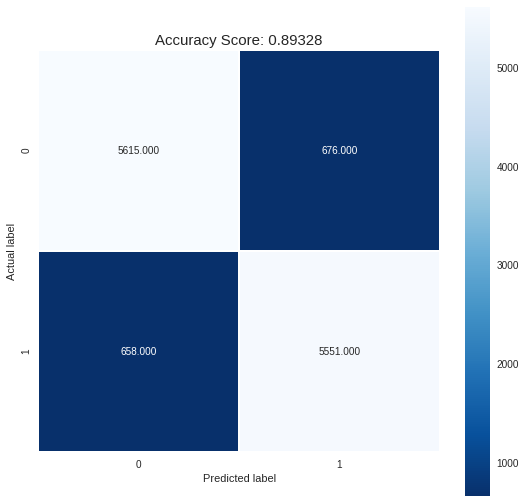

In [179]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### From the confusion matrix we can make the following conclusions:


1. Our model successfully predicted 5615 positives
2. Our model successfully predicted 5651 negatives.
3. Our model predicted 676 false positives
4. Our model predicted 658 false negatives




In [ ]:
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(test['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['id']=test['id']
pred.groupby('test_label').count()

#BOW 
![bow](http://uc-r.github.io/public/images/analytics/feature-engineering/bow-image.png)

In [24]:
from sklearn.model_selection import train_test_split
#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train['review'], targets, random_state=0)

In [25]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)

#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (37500, 6089098)
BOW_cv_test: (12500, 6089098)


In [26]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)

#transformed test reviews
tv_test_reviews=tv.transform(X_test)

#transformed test reviews
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (37500, 6089098)
Tfidf_test: (12500, 6089098)


In [28]:
from sklearn.linear_model import LogisticRegression
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


##Logistic regression model performane on test dataset

In [29]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 1]


##Accuracy

In [31]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7636
lr_tfidf_score : 0.7628


In [32]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.77      0.75      0.76      6291
    Negative       0.76      0.77      0.77      6209

    accuracy                           0.76     12500
   macro avg       0.76      0.76      0.76     12500
weighted avg       0.76      0.76      0.76     12500

              precision    recall  f1-score   support

    Positive       0.78      0.74      0.76      6291
    Negative       0.75      0.79      0.77      6209

    accuracy                           0.76     12500
   macro avg       0.76      0.76      0.76     12500
weighted avg       0.76      0.76      0.76     12500

